<a href="https://colab.research.google.com/github/hariomp/CERVICAL-CANCER-DETECTION-USING-GENETIC-ALGORITHM/blob/master/PROJECT_GA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scoop

     |████████████████████████████████| 604kB 2.7MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
  Created wheel for scoop: filename=scoop-0.7.1.1-cp36-none-any.whl size=72125 sha256=858751f11a4a03d0859f2581ac54122d5ace54b333d47aa8b829b94fff3e4fe5
  Stored in directory: /root/.cache/pip/wheels/9e/54/e5/5105f5602fdc4a1fbc911d786ca1114ee8f870ac00752d302f
Successfully built scoop


In [ ]:
pip install deap

     |████████████████████████████████| 163kB 2.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
from scoop import futures
from scipy import interpolate

In [ ]:
#importing warning features to ignore all kinds of warning.
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
#importing dataset
dataset = pd.read_csv('cervical.csv')

In [ ]:
dataset.head(10)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,1,1,0,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,1,0,0,0,0
9,44,3.0,15.0,?,1.0,1.266972909,2.8,0.0,0.0,?,?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


In [ ]:
# To replace ? from dataset
dataset = dataset.replace('?',0)

In [ ]:

# to drop null values if dataset have  Null Values in Rows/Columns
dataset=dataset.dropna()

In [ ]:

# dataset without Null values and ? mark
dataset.head(10)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
2,34,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,0
9,44,3.0,15.0,0,1.0,1.266972909,2.8,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0


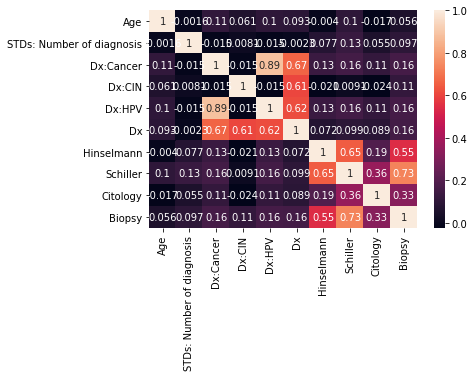

In [ ]:
#The heatmap is a way of representing the data in a 2-dimensional form. The data values are represented as colors in the graph.
#The goal of the heatmap is to provide a colored visual summary of information.
import seaborn as sns
sns.heatmap(dataset.corr(), annot=True)

In [ ]:
#Sklearn provides a very efficient tool for encoding the levels of categorical features into numeric values.
# LabelEncoder encode labels with a value between 0 and n_classes-1 where n is the number of distinct labels.
# If a label repeats it assigns the same value to as assigned earlier
le = LabelEncoder()
le.fit(dataset['Biopsy'])
allClasses = le.transform(dataset['Biopsy'])
allFeatures = dataset.drop(['Biopsy'], axis=1)

In [ ]:

X_TrainAndTest, X_Validation, y_TrainAndTest, y_Validation = train_test_split(allFeatures,
                                                                              allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_TrainAndTest,
                                                    y_TrainAndTest, test_size=0.20, random_state=42)
#RandomState exposes a number of methods for generating random numbers drawn from a variety of probability distributions.

In [ ]:

#  fitness function
#Fitness function is used in genetic programming and genetic algorithms to guide simulations towards optimal design solutions.
def FitnessEvaluate(individual, X_train, X_test, y_train, y_test):

    columns = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsedValues = X_train.drop(X_train.columns[columns], axis=1)
    X_trainFeatures = pd.get_dummies(X_trainParsedValues)
    X_testParsedValues = X_test.drop(X_test.columns[columns], axis=1)
    X_testFeatures = pd.get_dummies(X_testParsedValues)

    sharedFeatures = set(X_trainFeatures.columns) & set(X_testFeatures.columns)
    removeFromTrain = set(X_trainFeatures.columns) - sharedFeatures
    removeFromTest = set(X_testFeatures.columns) - sharedFeatures
    
    X_trainFeatures = X_trainFeatures.drop(list(removeFromTrain), axis=1)
    X_testFeatures = X_testFeatures.drop(list(removeFromTest), axis=1)
      
    # Applying Logistic Regression 
    
    clf = LogisticRegression()
    
    clf.fit(X_trainFeatures, y_train)
    predictions = clf.predict(X_testFeatures)
    accuracy = accuracy_score(y_test, predictions)

    return (accuracy,)

In [ ]:

#----------------- DEAP ( Distributed Evolutionary Algorithms in Python ) GLOBAL VARIABLES (can be viewable by SCOOP)-------------------------------
# Toolbox. class deap.base. Toolbox. A toolbox for evolution that contains the evolutionary operators .
from deap import  tools, algorithms,creator, base

# Create the Individuals
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Creating  a Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(dataset.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#  filling  toolbox
toolbox.register("evaluate", FitnessEvaluate, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# The halloffame module provides a way to keep track of the best individuals that ever lived in the evolutionary process.

def HallOfFame():

    # Initialize the  variables 
    PopNum = 100
    GenNum = 10
    pop = toolbox.population(n=PopNum)
    hof = tools.HallOfFame(PopNum * GenNum)
    '''we want to compile statistics on what is going on in the optimization. 
    The Statistics are able to compile such data on arbitrary attributes of any designated object. 
    To do that, one needs to register the desired statistic functions inside the stats object using the exact same syntax as in the toolbox.'''

    stats = tools.Statistics(lambda index : index.fitness.values)
    stats.register("Average", np.mean)
    stats.register("Standard Deviation", np.std)
    stats.register("Min", np.min)
    stats.register("Max", np.max)

    
    '''When using a predefined algorithm such as eaSimple(), eaMuPlusLambda(), eaMuCommaLambda(), or eaGenerateUpdate(), 
    the statistics object previously created can be given as argument to the algorithm.'''
    
    # Launching  genetic algorithm

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=GenNum, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

In [ ]:
def Metrics(hof):

    #  list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
    
    # Gathering  fitness data from each percentile
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = FitnessEvaluate(individual, X_TrainAndTest, X_Validation, y_TrainAndTest, y_Validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    return testAccuracyList, validationAccuracyList, individualList, percentileList

In [ ]:

if __name__ == '__main__':

#    First, we will apply logistic regression using all the features to get a Baseline accuracy.

    individual = [1 for i in range(len(allFeatures.columns))]
    
    testAccuracy = FitnessEvaluate(individual, X_train, X_test, y_train, y_test)
    
    validationAccuracy = FitnessEvaluate(individual, X_TrainAndTest, X_Validation, y_TrainAndTest, y_Validation)
    
    print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
    
    print('\nValidation accuracy with all features: ' + str(validationAccuracy[0]) + '\n')
    
    '''
    Now, we  apply the Genetic algorithm to choose a subset of features from the dataset 
 that gives a better accuracy than the baseline.
 
    '''
 
   
  
    #calling hall of fame module to find out the individuals survived in evolutionary process
    HallofFame = HallOfFame()
    
    #calling metrices module which returns the values of testAccuracyList, validationAccuracyList, individualList, percentileList respectively.
    testAccuracyList, validationAccuracyList, individualList, percentileList = Metrics(HallofFame)

    # Get a list of subsets that performed best on validation data
    MaxValueAccuracySubsetIndicies = [index for index in range(len(validationAccuracyList)) 
                               if validationAccuracyList[index] == max(validationAccuracyList)]
    
    maxValueIndividuals = [individualList[index] for index in MaxValueAccuracySubsetIndicies]
    
    maxValueSubsets = [[list(allFeatures)[index] for index in range(len(individual))
                      if individual[index] == 1] for individual in maxValueIndividuals]

    
    print('\n---Optimal Feature Subset(s)---\n')
    for index in range(len(MaxValueAccuracySubsetIndicies)):
        
        print(' \n The  Percentile: \t\t\t' + str(percentileList[MaxValueAccuracySubsetIndicies[index]]))
        print(' \n The Validation Accuracy: \t\t' + str(validationAccuracyList[MaxValueAccuracySubsetIndicies[index]]))
        print(' \n Individual: \t' + str(maxValueIndividuals[index]))
        print(' \n Number of Features In Subset: \t' + str(len(maxValueSubsets[index])))
        print(' \n Feature Subset \n : ' + str(maxValueSubsets[index]))
        

Test accuracy with all features: 0.9637681159420289
Validation accuracy with all features: 0.9476744186046512

gen nevals Average Standard Deviation Min Max
0 100 0.959203 0.00959454 0.942029 0.978261 1 60 0.966594 0.0085676 0.942029 0.978261 2 55 0.971957 0.00699979 0.942029 0.978261 3 69 0.973913 0.00695048 0.942029 0.978261 4 61 0.97558 0.00611922 0.949275 0.978261 5 58 0.977174 0.0034563 0.963768 0.978261 6 67 0.977101 0.00393179 0.949275 0.978261 7 70 0.976884 0.00431083 0.949275 0.978261 8 57 0.976522 0.00513624 0.949275 0.978261 9 60 0.976739 0.00359336 0.963768 0.978261 10 73 0.976377 0.0054824 0.949275 0.978261

---Optimal Feature Subset(s)---

The Percentile: 0.3029259896729776

The Validation Accuracy: 0.9709302325581395

Individual: [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]

Number of Features In Subset: 13

Feature Subset : ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes (years)', 'STDs (number)', 'STDs:vaginal condylomatosis', 'STDs:syphilis', 'STDs:molluscum contagiosum', 'STDs:Hepatitis B', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis', 'Dx', 'Hinselmann']

The Percentile: 0.40619621342512907

The Validation Accuracy: 0.9709302325581395

Individual: [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]

Number of Features In Subset: 17

Feature Subset : ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'STDs (number)', 'STDs:cervical condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis', 'Hinselmann']

The Percentile: 0.5851979345955249

The Validation Accuracy: 0.9709302325581395

Individual: [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]

Number of Features In Subset: 18

Feature Subset : ['First sexual intercourse', 'Num of pregnancies', 'Smokes', 'IUD', 'IUD (years)', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:HPV', 'Hinselmann', 'Schiller']

The Percentile: 0.810671256454389

The Validation Accuracy: 0.9709302325581395

Individual: [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]

Number of Features In Subset: 15

Feature Subset : ['First sexual intercourse', 'Smokes', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:cervical condylomatosis', 'STDs:syphilis', 'STDs:HIV', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:CIN', 'Dx:HPV', 'Hinselmann']